<h1 align = "center">1. Libraries and Utilities</h1>

In [84]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import re
import string
import torch
from collections import Counter
import xgboost as xgb
import plotnine
from plotnine import *

import sklearn
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.preprocessing import LabelEncoder
from sklearn.datasets import load_svmlight_files
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score 
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from torchsampler import ImbalancedDatasetSampler
from xgboost.sklearn import XGBClassifier
from xgboost.sklearn import XGBRegressor
from xgboost.sklearn import XGBRFRegressor
from xgboost import plot_importance
from xgboost import plot_tree
from sklearn.externals import joblib
from sklearn.impute import SimpleImputer

# visualization modules
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from pyecharts.charts.basic_charts import pie
import missingno as msno


<h1 align = "center">2. Data Preprocessing</h1>


In [117]:
df_origin = pd.read_csv('./../data/f2.csv')

df = df_origin.replace(['Benign/Likely_benign', 'Pathogenic/Likely_pathogenic'], ['Likely_benign', 'Likely_pathogenic']) 

df.drop(df[(df['CLNSIG'] != 'Benign') & (df['CLNSIG'] != 'Pathogenic') & (df['CLNSIG'] != 'Likely_benign') & (df['CLNSIG'] != 'Likely_pathogenic')].index, inplace=True)

df.reset_index(inplace=True)

col_names = ['CLNSIG', 'Consequence', 'EXON', 'INTRON', 'SIFT','PolyPhen', 'FATHMM_pred', 'MutationTaster_pred', 'PROVEAN_pred', 'Polyphen2_HDIV_pred', 'Polyphen2_HVAR_pred', 'SIFT_pred', 'IMPACT', 'M-CAP_pred', 'MetaSVM_pred', 'MutationAssessor_pred', 'rf_score', 'ada_score', 'CADD_phred', 'CADD_raw', 'CADD_raw_rankscore', 'DANN_rankscore', 'DANN_score', 'Eigen-PC-raw', 'MutPred_rankscore', 'MutPred_score', 'REVEL_rankscore', 'REVEL_score', 'SiPhy_29way_logOdds', 'SiPhy_29way_logOdds_rankscore', 'VEST3_rankscore', 'VEST3_score', 'phastCons100way_vertebrate', 'phastCons20way_mammalian', 'phyloP100way_vertebrate', 'phyloP20way_mammalian', 'GERP++_RS', 'GERP++_NR', 'MAX_AF', 'gnomadWES_AF_POPMAX']
df = df[col_names]

KeyError: "['gnomadWES_AF_POPMAX'] not in index"

In [86]:
df['CLNSIG'].value_counts()

Likely_benign        171560
Benign                92461
Pathogenic            82944
Likely_pathogenic     47540
Name: CLNSIG, dtype: int64

In [87]:
def format(df):
    # Consequence
    con_split = df['Consequence'].apply(lambda x: x if pd.isna(x) else x.split('&'))
    mlb = MultiLabelBinarizer()
    con_df = pd.DataFrame(mlb.fit_transform(con_split), columns=mlb.classes_)
    
    pca = PCA(n_components=12)
    principalComponents = pca.fit_transform(con_df)
    principalDf = pd.DataFrame(data=principalComponents)
    
    df_new = df.merge(principalDf, left_on=df.index, right_on=principalDf.index)
    # EXON
    df_new['EXON'] = df_new['EXON'].apply(lambda x: 0 if pd.isna(x) else 1)

    # INTRON
    df_new['INTRON'] = df_new['INTRON'].apply(lambda x: 0 if pd.isna(x) else 1)

    # SIFT
    df_new['SIFT'] = df_new['SIFT'].apply(lambda x: x if pd.isna(x) else re.sub(r"\(.*\)", "", x))

    # PolyPhen
    df_new['PolyPhen'] = df_new['PolyPhen'].apply(lambda x: x if pd.isna(x) else re.sub(r"\(.*\)", "", x))

    # FATHMM_pred
    df_new['FATHMM_pred'] = df_new['FATHMM_pred'].apply(lambda x: x if pd.isna(x) else max(string.ascii_uppercase, key=x.count))

    # MutationTaster_pred D N A
    # df['MutationTaster_pred'] = df['MutationTaster_pred'].apply(lambda x: x if pd.isna(x) else x.count('D')/(x.count('D')+x.count('N')))
    df_new['MutationTaster_pred'] = df_new['MutationTaster_pred'].apply(lambda x: x if pd.isna(x) else max(string.ascii_uppercase, key=x.count))

    # PROVEAN_pred
    df_new['PROVEAN_pred'] = df_new['PROVEAN_pred'].apply(lambda x: x if pd.isna(x) else max(string.ascii_uppercase, key=x.count))

    # Polyphen2_HDIV_pred
    df_new['Polyphen2_HDIV_pred'] = df_new['Polyphen2_HDIV_pred'].apply(lambda x: x if pd.isna(x) else max(string.ascii_uppercase, key=x.count))

    # Polyphen2_HVAR_pred
    df_new['Polyphen2_HVAR_pred'] = df_new['Polyphen2_HVAR_pred'].apply(lambda x: x if pd.isna(x) else max(string.ascii_uppercase, key=x.count))

    # SIFT_pred
    df_new['SIFT_pred'] = df_new['SIFT_pred'].apply(lambda x: x if pd.isna(x) else max(string.ascii_uppercase, key=x.count))

    # VEST3_score
    df_new['VEST3_score'] = df_new['VEST3_score'].apply(lambda x: x if pd.isna(x) else np.mean(list(map(eval, x.split('&')))))
    
    # MAX_AF
    # df_new['MAX_AF'].fillna(0, inplace=True)
    
    return df_new

In [88]:
def label(df):    
    le = LabelEncoder()
    df_new = df.copy()
    df_new['SIFT'] = le.fit_transform(df['SIFT'])
    df_new['PolyPhen'] = le.fit_transform(df['PolyPhen'])
    df_new['FATHMM_pred'] = le.fit_transform(df['FATHMM_pred'])
    df_new['MutationTaster_pred'] = le.fit_transform(df['MutationTaster_pred'])
    df_new['PROVEAN_pred'] = le.fit_transform(df['PROVEAN_pred'])
    df_new['Polyphen2_HDIV_pred'] = le.fit_transform(df['Polyphen2_HDIV_pred'])
    df_new['Polyphen2_HVAR_pred'] = le.fit_transform(df['Polyphen2_HVAR_pred'])
    df_new['SIFT_pred'] = le.fit_transform(df['SIFT_pred'])
    df_new['IMPACT'] = le.fit_transform(df['IMPACT'])
    # df['LRT_pred'] = le.fit_transform(df['LRT_pred'])
    df_new['M-CAP_pred'] = le.fit_transform(df['M-CAP_pred'])
    df_new['MetaSVM_pred'] = le.fit_transform(df['MetaSVM_pred'])
    df_new['MutationAssessor_pred'] = le.fit_transform(df['MutationAssessor_pred'])
    if 'CLNSIG' in df.columns:
        df_new['CLNSIG'] = le.fit_transform(df['CLNSIG'])
    return df_new

In [89]:
df_formatted = format(df)

In [90]:
#设置列不限制数量
# pd.set_option('display.max_columns',None)

# df.info()

In [91]:
#设置列不限制数量
# pd.set_option('display.max_columns',None)

# print(df_formatted.info())
# stop

In [92]:
df_labeled = label(df_formatted)

<h1 align = "center">3. Model</h1>


==========================================================================================================

In [93]:
df_full = df_labeled[df_labeled['CADD_phred'].notna()]
df_missing = df_labeled[df_labeled['CADD_phred'].isna()]

In [94]:
input_cols = ['EXON', 'INTRON', 'SIFT','PolyPhen', 'FATHMM_pred', 'MutationTaster_pred', 'PROVEAN_pred', 'Polyphen2_HDIV_pred', 'Polyphen2_HVAR_pred', 'SIFT_pred', 'IMPACT', 'M-CAP_pred', 'MetaSVM_pred', 'MutationAssessor_pred', 'rf_score', 'ada_score', 'CADD_phred', 'CADD_raw', 'CADD_raw_rankscore', 'DANN_rankscore', 'DANN_score', 'Eigen-PC-raw', 'MutPred_rankscore', 'MutPred_score', 'REVEL_rankscore', 'REVEL_score', 'SiPhy_29way_logOdds', 'SiPhy_29way_logOdds_rankscore', 'VEST3_rankscore', 'VEST3_score', 'phastCons100way_vertebrate', 'phastCons20way_mammalian', 'phyloP100way_vertebrate', 'phyloP20way_mammalian', 'GERP++_RS', 'GERP++_NR', 'MAX_AF',  0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

inputs_full = df_full[input_cols]
target_full = df_full['CLNSIG']

inputs_missing = df_missing[input_cols]
target_missing = df_missing['CLNSIG']

In [95]:
ros = RandomOverSampler(random_state=0)

X_train_full, X_test_full, y_train_full, y_test_full = train_test_split(inputs_full, target_full, test_size = 0.25, shuffle = True)
X_train_full, y_train_full = ros.fit_resample(X_train_full, y_train_full)

X_train_missing, X_test_missing, y_train_missing, y_test_missing = train_test_split(inputs_missing, target_missing, test_size = 0.25, shuffle = True)
X_train_missing, y_train_missing = ros.fit_resample(X_train_missing, y_train_missing)

In [96]:
bst_full = XGBRegressor()
bst_missing = XGBRegressor()

In [97]:
bst_full.fit(X_train_full, y_train_full)
bst_missing.fit(X_train_missing, y_train_missing)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [98]:
pred_full = bst_full.predict(X_test_full)
pred_missing = bst_missing.predict(X_test_missing)

In [99]:
v_full = pd.DataFrame(y_test_full)
v_full['Regressor_pre'] = pred_full
v_full['Pathon/Beni'] = v_full['CLNSIG'].apply(lambda x: 1 if x >= 2 else 0)

v_missing = pd.DataFrame(y_test_missing)
v_missing['Regressor_pre'] = pred_missing
v_missing['Pathon/Beni'] = v_missing['CLNSIG'].apply(lambda x: 1 if x >= 2 else 0)

<AxesSubplot:xlabel='Regressor_pre', ylabel='Density'>

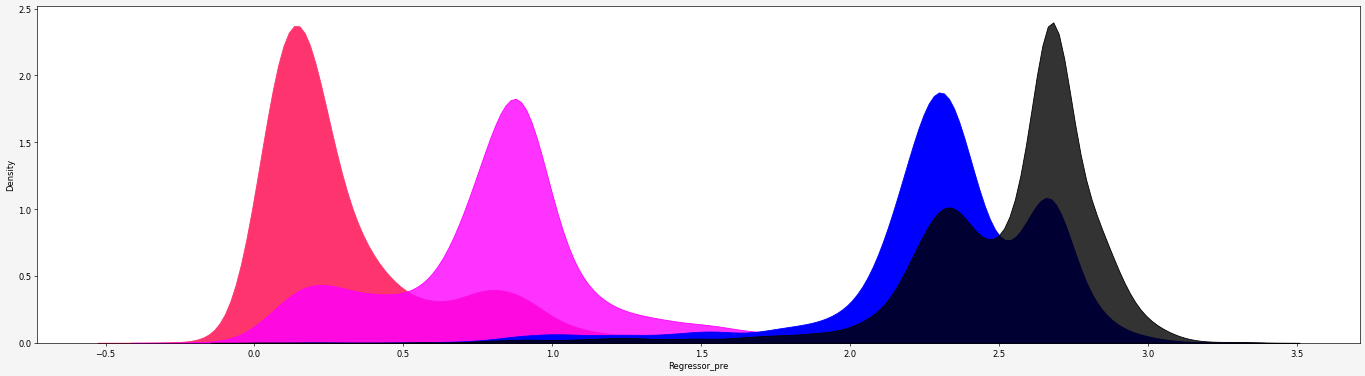

In [100]:
fig = plt.figure(figsize=(72, 52), dpi=60)

gs = fig.add_gridspec(20, 20)
# gs.update(wspace=1, hspace=0.05)
ax1 = fig.add_subplot(gs[1:4, 0:8])

fig.patch.set_facecolor('#f6f5f5')

sns.kdeplot(data=v_full[v_full['CLNSIG'] == 0], x='Regressor_pre', ax=ax1, shade=True, color='#fe346e', alpha=1)
sns.kdeplot(data=v_full[v_full['CLNSIG'] == 1], x='Regressor_pre', ax=ax1, shade=True, color='#FF00FF', alpha=0.8) 
sns.kdeplot(data=v_full[v_full['CLNSIG'] == 2], x='Regressor_pre', ax=ax1, shade=True, color='#0000FF', alpha=1) 
sns.kdeplot(data=v_full[v_full['CLNSIG'] == 3], x='Regressor_pre', ax=ax1, shade=True, color='#000000', alpha=0.8)

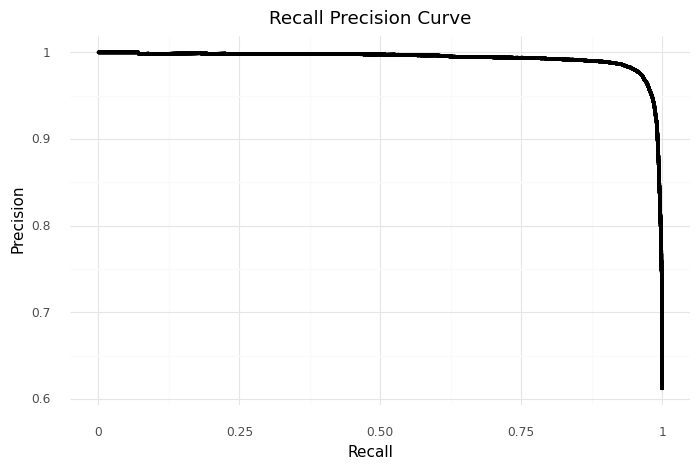

<ggplot: (158577187922)>

In [101]:
# 创建PR曲线
precision, recall, thresholds = precision_recall_curve(v_full['Pathon/Beni'], pred_full)

# 绘制ROC曲线
df_recall_precision = pd.DataFrame({'Precision':precision[:-1],
                                    'Recall':recall[:-1],
                                    'Threshold':thresholds})
df_recall_precision.head()

# 创建数据图
plotnine.options.figure_size = (8, 4.8)
(
    ggplot(data = df_recall_precision)+
    geom_point(aes(x = 'Recall',
                   y = 'Precision'),
               size = 0.4)+
    geom_line(aes(x = 'Recall',
                  y = 'Precision'))+
    labs(title = 'Recall Precision Curve')+
    xlab('Recall')+
    ylab('Precision')+
    theme_minimal()
)

Best Threshold: 1.568600058555603 with F-Score: 0.9689
Recall: 0.9648, Precision: 0.9731


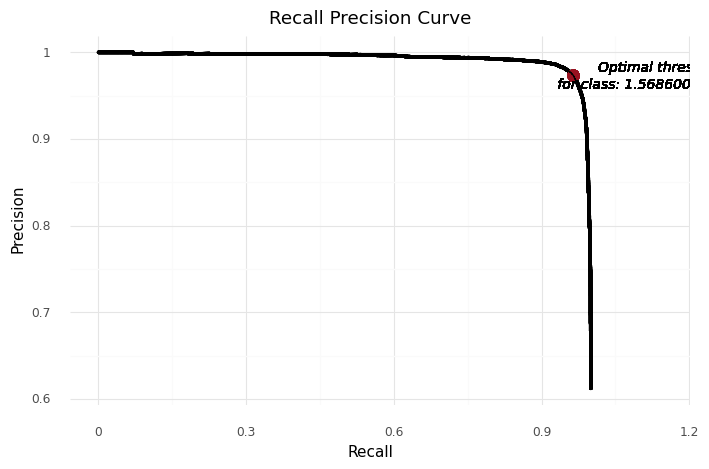

<ggplot: (158752269210)>

In [102]:
# precision, recall, thresholds = precision_recall_curve(v_full['Pathon/Beni'], pred_full)

# 计算F分数
fscore = (2 * precision * recall) / (precision + recall)

# 找到最佳阈值
index = np.argmax(fscore)
thresholdOpt = round(thresholds[index], ndigits = 4)
fscoreOpt = round(fscore[index], ndigits = 4)
recallOpt = round(recall[index], ndigits = 4)
precisionOpt = round(precision[index], ndigits = 4)
print('Best Threshold: {} with F-Score: {}'.format(thresholdOpt, fscoreOpt))
print('Recall: {}, Precision: {}'.format(recallOpt, precisionOpt))

# 创建数据图
plotnine.options.figure_size = (8, 4.8)
(
    ggplot(data = df_recall_precision)+
    geom_point(aes(x = 'Recall',
                   y = 'Precision'),
               size = 0.4)+
    # 最佳阈值
    geom_point(aes(x = recallOpt,
                   y = precisionOpt),
               color = '#981220',
               size = 4)+
    geom_line(aes(x = 'Recall',
                  y = 'Precision'))+
    # 注释
    geom_text(aes(x = recallOpt,
                  y = precisionOpt),
              label = 'Optimal threshold \n for class: {}'.format(thresholdOpt),
              nudge_x = 0.18,
              nudge_y = 0,
              size = 10,
              fontstyle = 'italic')+
    labs(title = 'Recall Precision Curve')+
    xlab('Recall')+
    ylab('Precision')+
    theme_minimal()
)

In [103]:
v_full['class'] = v_full['Regressor_pre'].apply(lambda x: 1 if x >= thresholdOpt else 0)
print(classification_report(v_full['Pathon/Beni'], v_full['class']))

              precision    recall  f1-score   support

           0       0.95      0.96      0.95      9919
           1       0.97      0.96      0.97     15296

    accuracy                           0.96     25215
   macro avg       0.96      0.96      0.96     25215
weighted avg       0.96      0.96      0.96     25215



<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

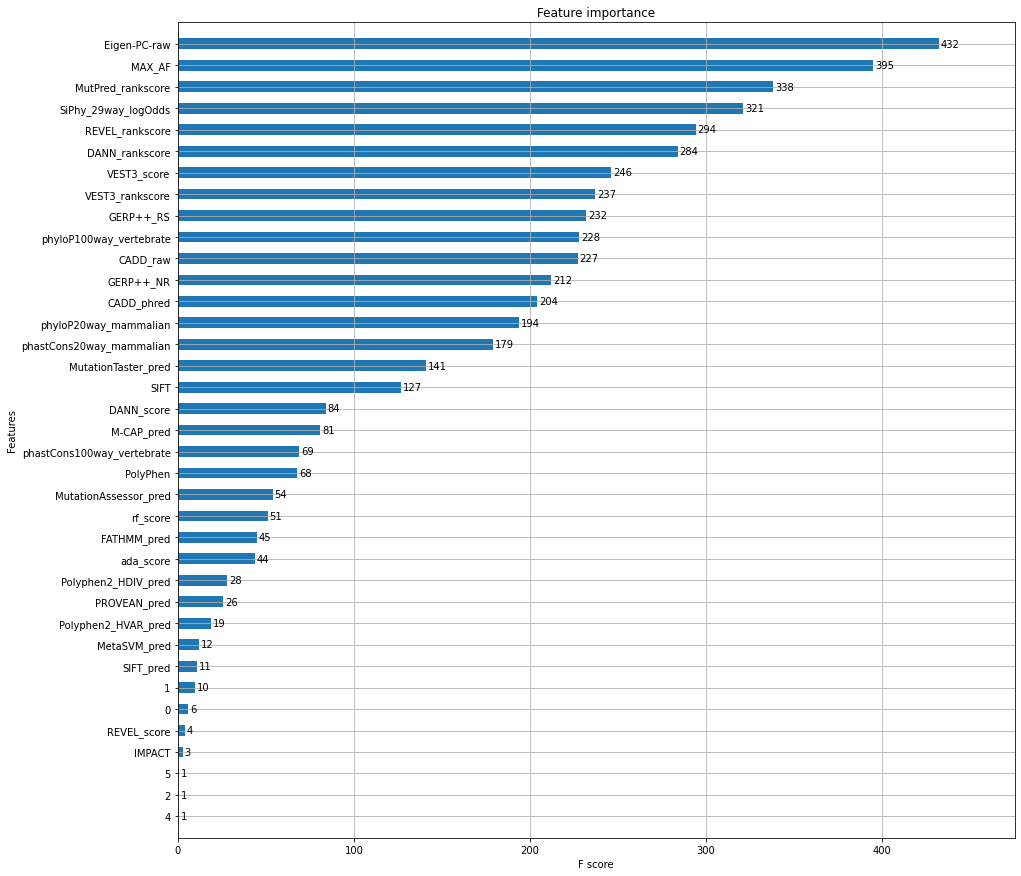

In [104]:
fig, ax = plt.subplots(figsize=(15, 15))
plot_importance(bst_full, height=0.5, ax=ax)

In [105]:
joblib.dump(bst_full, 'XGBoostRegresor_full_1.0.pkl')

['XGBoostRegresor_full_1.0.pkl']

<AxesSubplot:xlabel='Regressor_pre', ylabel='Density'>

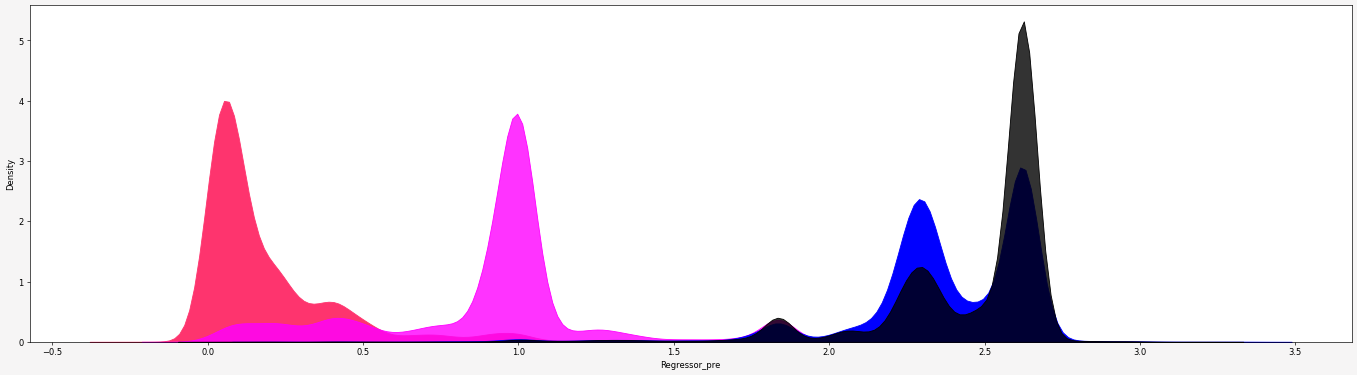

In [106]:
fig = plt.figure(figsize=(72, 52), dpi=60)

gs = fig.add_gridspec(20, 20)
# gs.update(wspace=1, hspace=0.05)
ax1 = fig.add_subplot(gs[1:4, 0:8])

fig.patch.set_facecolor('#f6f5f5')

sns.kdeplot(data=v_missing[v_missing['CLNSIG'] == 0], x='Regressor_pre', ax=ax1, shade=True, color='#fe346e', alpha=1)
sns.kdeplot(data=v_missing[v_missing['CLNSIG'] == 1], x='Regressor_pre', ax=ax1, shade=True, color='#FF00FF', alpha=0.8) 
sns.kdeplot(data=v_missing[v_missing['CLNSIG'] == 2], x='Regressor_pre', ax=ax1, shade=True, color='#0000FF', alpha=1) 
sns.kdeplot(data=v_missing[v_missing['CLNSIG'] == 3], x='Regressor_pre', ax=ax1, shade=True, color='#000000', alpha=0.8)

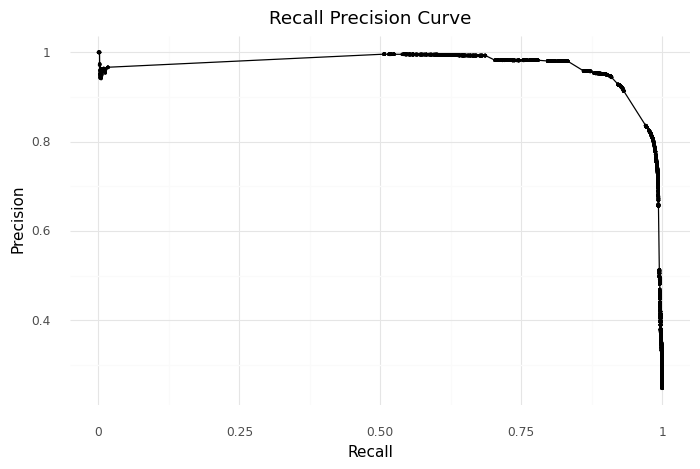

<ggplot: (158539327672)>

In [107]:
# 创建PR曲线
precision, recall, thresholds = precision_recall_curve(v_missing['Pathon/Beni'], pred_missing)

# 绘制ROC曲线
df_recall_precision = pd.DataFrame({'Precision':precision[:-1],
                                    'Recall':recall[:-1],
                                    'Threshold':thresholds})
df_recall_precision.head()

# 创建数据图
plotnine.options.figure_size = (8, 4.8)
(
    ggplot(data = df_recall_precision)+
    geom_point(aes(x = 'Recall',
                   y = 'Precision'),
               size = 0.4)+
    geom_line(aes(x = 'Recall',
                  y = 'Precision'))+
    labs(title = 'Recall Precision Curve')+
    xlab('Recall')+
    ylab('Precision')+
    theme_minimal()
)

Best Threshold: 2.0768001079559326 with F-Score: 0.9273
Recall: 0.9086, Precision: 0.9467


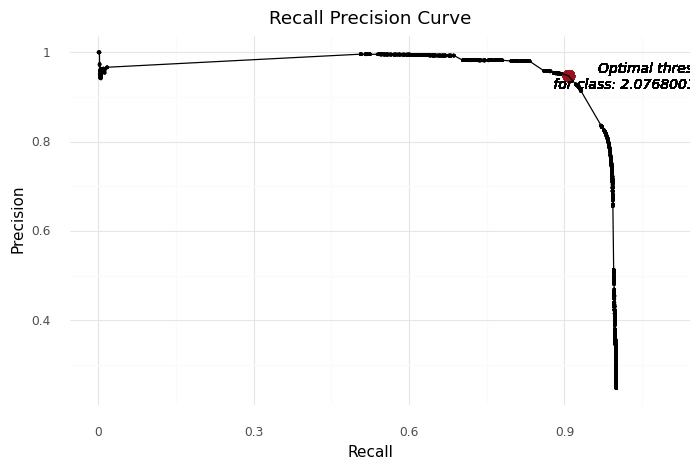

<ggplot: (158539478007)>

In [108]:
precision, recall, thresholds = precision_recall_curve(v_missing['Pathon/Beni'], pred_missing)

# 计算F分数
fscore = (2 * precision * recall) / (precision + recall)

# 找到最佳阈值
index = np.argmax(fscore)
thresholdOpt = round(thresholds[index], ndigits = 4)
fscoreOpt = round(fscore[index], ndigits = 4)
recallOpt = round(recall[index], ndigits = 4)
precisionOpt = round(precision[index], ndigits = 4)
print('Best Threshold: {} with F-Score: {}'.format(thresholdOpt, fscoreOpt))
print('Recall: {}, Precision: {}'.format(recallOpt, precisionOpt))

# 创建数据图
plotnine.options.figure_size = (8, 4.8)
(
    ggplot(data = df_recall_precision)+
    geom_point(aes(x = 'Recall',
                   y = 'Precision'),
               size = 0.4)+
    # 最佳阈值
    geom_point(aes(x = recallOpt,
                   y = precisionOpt),
               color = '#981220',
               size = 4)+
    geom_line(aes(x = 'Recall',
                  y = 'Precision'))+
    # 注释
    geom_text(aes(x = recallOpt,
                  y = precisionOpt),
              label = 'Optimal threshold \n for class: {}'.format(thresholdOpt),
              nudge_x = 0.18,
              nudge_y = 0,
              size = 10,
              fontstyle = 'italic')+
    labs(title = 'Recall Precision Curve')+
    xlab('Recall')+
    ylab('Precision')+
    theme_minimal()
)

In [109]:
v_missing['class'] = v_missing['Regressor_pre'].apply(lambda x: 1 if x >= thresholdOpt else 0)
print(classification_report(v_missing['Pathon/Beni'], v_missing['class']))

              precision    recall  f1-score   support

           0       0.97      0.98      0.98     56157
           1       0.95      0.91      0.93     17255

    accuracy                           0.97     73412
   macro avg       0.96      0.95      0.95     73412
weighted avg       0.97      0.97      0.97     73412



<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

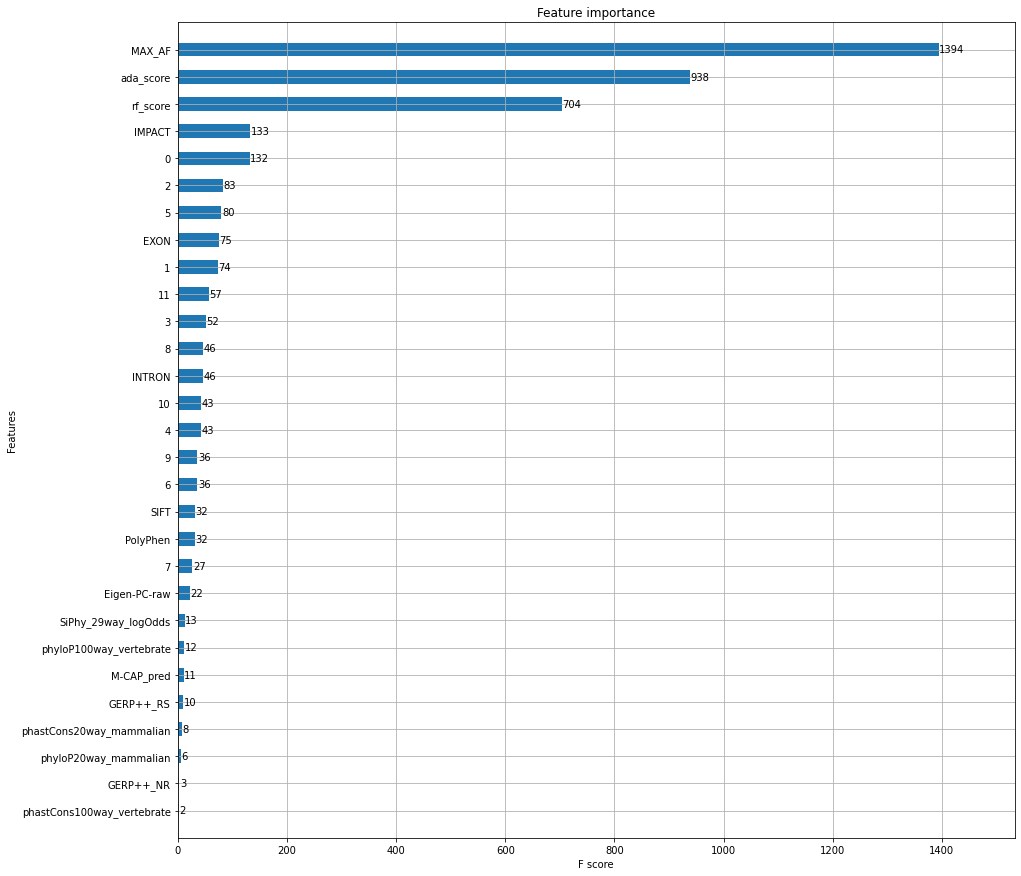

In [110]:
fig, ax = plt.subplots(figsize=(15, 15))
plot_importance(bst_missing, height=0.5, ax=ax)

In [111]:
joblib.dump(bst_missing, 'XGBoostRegresor_missing_1.0.pkl')

['XGBoostRegresor_missing_1.0.pkl']

==========================================================================================================

In [112]:
# Inputs & Target
input_cols = ['EXON', 'INTRON', 'SIFT','PolyPhen', 'FATHMM_pred', 'MutationTaster_pred', 'PROVEAN_pred', 'Polyphen2_HDIV_pred', 'Polyphen2_HVAR_pred', 'SIFT_pred', 'IMPACT', 'M-CAP_pred', 'MetaSVM_pred', 'MutationAssessor_pred', 'rf_score', 'ada_score', 'CADD_phred', 'CADD_raw', 'CADD_raw_rankscore', 'DANN_rankscore', 'DANN_score', 'Eigen-PC-raw', 'MutPred_rankscore', 'MutPred_score', 'REVEL_rankscore', 'REVEL_score', 'SiPhy_29way_logOdds', 'SiPhy_29way_logOdds_rankscore', 'VEST3_rankscore', 'VEST3_score', 'phastCons100way_vertebrate', 'phastCons20way_mammalian', 'phyloP100way_vertebrate', 'phyloP20way_mammalian', 'GERP++_RS', 'GERP++_NR', 'MAX_AF',  0, 1, 2, 3, 4]
inputs = df_labeled[input_cols]
target = df_labeled['CLNSIG']

In [113]:
X_train, X_test, y_train, y_test = train_test_split(inputs, target, test_size = 0.25, shuffle = True)

ros = RandomOverSampler(random_state=0)
X_train, y_train = ros.fit_resample(X_train, y_train)

# smote = SMOTE()
# X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)


# train_loader = torch.utils.data.DataLoader(
#     df,
#     sampler=ImbalancedDatasetSampler(df),
#     batch_size=args.batch_size,
#     **kwargs
# )

# print(y_train.value_counts())

In [114]:
v = pd.DataFrame(y_test)
v['Regressor_pre'] = pre
v['Pathon/Beni'] = v['CLNSIG'].apply(lambda x: 1 if x >= 2 else 0)

NameError: name 'pre' is not defined

([<matplotlib.patches.Wedge at 0x2ea30c4d580>,
 [Text(0.7778174593052024, 0.7778174593052024, 'Likely_benign'),
  Text(-0.7778174593052023, 0.7778174593052024, 'Pathogenic'),
  Text(-0.7778174593052025, -0.7778174593052023, 'Likely_pathogenic'),
  Text(0.7778174593052022, -0.7778174593052025, 'Benign')],
 [Text(0.4242640687119285, 0.4242640687119285, '25.00%'),
  Text(-0.42426406871192845, 0.4242640687119285, '25.00%'),
  Text(-0.4242640687119286, -0.42426406871192845, '25.00%'),
  Text(0.4242640687119284, -0.4242640687119286, '25.00%')])

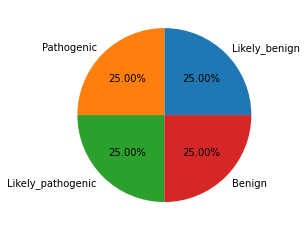

In [ ]:
plt.pie(y_train.value_counts(), labels=df['CLNSIG'].unique(), autopct='%.2f%%')

In [ ]:
bst = XGBRegressor()

In [ ]:
bst.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [ ]:
pre = bst.predict(X_test)

In [ ]:
v = pd.DataFrame(y_test)
v['Regressor_pre'] = pre
v['Pathon/Beni'] = v['CLNSIG'].apply(lambda x: 1 if x >= 2 else 0)

<AxesSubplot:xlabel='Regressor_pre', ylabel='Density'>

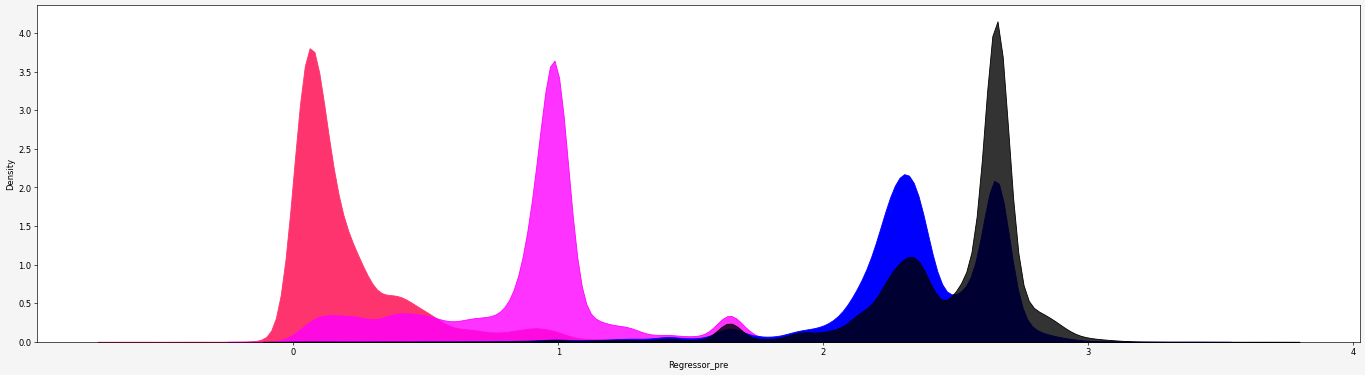

In [ ]:
fig = plt.figure(figsize=(72, 52), dpi=60)

gs = fig.add_gridspec(20, 20)
# gs.update(wspace=1, hspace=0.05)
ax1 = fig.add_subplot(gs[1:4, 0:8])

fig.patch.set_facecolor('#f6f5f5')

sns.kdeplot(data=v[v['CLNSIG'] == 0], x='Regressor_pre', ax=ax1, shade=True, color='#fe346e', alpha=1)
sns.kdeplot(data=v[v['CLNSIG'] == 1], x='Regressor_pre', ax=ax1, shade=True, color='#FF00FF', alpha=0.8) 
sns.kdeplot(data=v[v['CLNSIG'] == 2], x='Regressor_pre', ax=ax1, shade=True, color='#0000FF', alpha=1) 
sns.kdeplot(data=v[v['CLNSIG'] == 3], x='Regressor_pre', ax=ax1, shade=True, color='#000000', alpha=0.8)

In [ ]:
# fpr, tpr, thresholds = roc_curve(v['Pathon/Beni'], pre)

# df_fpr_tpr = pd.DataFrame({'FPR': fpr, 'TPR': tpr, 'Threshold': thresholds})

# plotnine.options.figure_size = (8, 4.8)
# (
#     ggplot(data = df_fpr_tpr)+
#     geom_point(aes(x = 'FPR',
#                    y = 'TPR'),
#                size = 0.4)+
#     geom_line(aes(x = 'FPR',
#                   y = 'TPR'))+
#     labs(title = 'ROC Curve')+
#     xlab('False Positive Rate')+
#     ylab('True Positive Rate')+
#     theme_minimal()
# )

In [ ]:
# # 计算G-mean
# gmean = np.sqrt(tpr * (1 - fpr))

# # 查找最佳阈值
# index = np.argmax(gmean)
# thresholdOpt = round(thresholds[index], ndigits = 4)
# gmeanOpt = round(gmean[index], ndigits = 4)
# fprOpt = round(fpr[index], ndigits = 4)
# tprOpt = round(tpr[index], ndigits = 4)
# print('Best Threshold: {} with G-Mean: {}'.format(thresholdOpt, gmeanOpt))
# print('FPR: {}, TPR: {}'.format(fprOpt, tprOpt))

# # 创建数据
# plotnine.options.figure_size = (8, 4.8)
# (
#     ggplot(data = df_fpr_tpr)+
#     geom_point(aes(x = 'FPR',
#                    y = 'TPR'),
#                size = 0.4)+
#     # 最佳阈值
#     geom_point(aes(x = fprOpt,
#                    y = tprOpt),
#                color = '#981220',
#                size = 4)+
#     geom_line(aes(x = 'FPR',
#                   y = 'TPR'))+
#     geom_text(aes(x = fprOpt,
#                   y = tprOpt),
#               label = 'Optimal threshold \n for class: {}'.format(thresholdOpt),
#               nudge_x = 0.14,
#               nudge_y = -0.10,
#               size = 10,
#               fontstyle = 'italic')+
#     labs(title = 'ROC Curve')+
#     xlab('False Positive Rate (FPR)')+
#     ylab('True Positive Rate (TPR)')+
#     theme_minimal()
# )

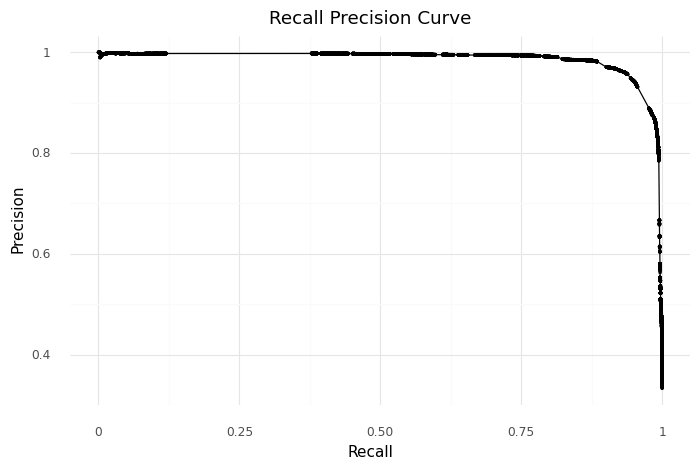

<ggplot: (200316326364)>

In [ ]:
# 创建PR曲线
precision, recall, thresholds = precision_recall_curve(v['Pathon/Beni'], pre)

# 绘制ROC曲线
df_recall_precision = pd.DataFrame({'Precision':precision[:-1],
                                    'Recall':recall[:-1],
                                    'Threshold':thresholds})
df_recall_precision.head()

# 创建数据图
plotnine.options.figure_size = (8, 4.8)
(
    ggplot(data = df_recall_precision)+
    geom_point(aes(x = 'Recall',
                   y = 'Precision'),
               size = 0.4)+
    geom_line(aes(x = 'Recall',
                  y = 'Precision'))+
    labs(title = 'Recall Precision Curve')+
    xlab('Recall')+
    ylab('Precision')+
    theme_minimal()
)

Best Threshold: 1.910099983215332 with F-Score: 0.9475
Recall: 0.9386, Precision: 0.9565


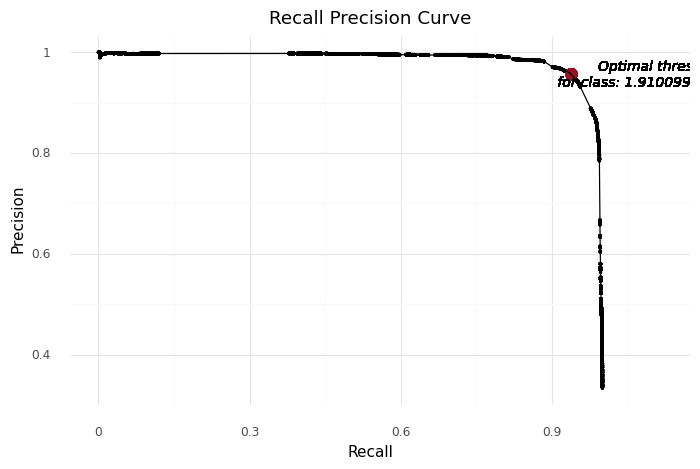

<ggplot: (200328603359)>

In [ ]:
# 计算F分数
fscore = (2 * precision * recall) / (precision + recall)

# 找到最佳阈值
index = np.argmax(fscore)
thresholdOpt = round(thresholds[index], ndigits = 4)
fscoreOpt = round(fscore[index], ndigits = 4)
recallOpt = round(recall[index], ndigits = 4)
precisionOpt = round(precision[index], ndigits = 4)
print('Best Threshold: {} with F-Score: {}'.format(thresholdOpt, fscoreOpt))
print('Recall: {}, Precision: {}'.format(recallOpt, precisionOpt))

# 创建数据图
plotnine.options.figure_size = (8, 4.8)
(
    ggplot(data = df_recall_precision)+
    geom_point(aes(x = 'Recall',
                   y = 'Precision'),
               size = 0.4)+
    # 最佳阈值
    geom_point(aes(x = recallOpt,
                   y = precisionOpt),
               color = '#981220',
               size = 4)+
    geom_line(aes(x = 'Recall',
                  y = 'Precision'))+
    # 注释
    geom_text(aes(x = recallOpt,
                  y = precisionOpt),
              label = 'Optimal threshold \n for class: {}'.format(thresholdOpt),
              nudge_x = 0.18,
              nudge_y = 0,
              size = 10,
              fontstyle = 'italic')+
    labs(title = 'Recall Precision Curve')+
    xlab('Recall')+
    ylab('Precision')+
    theme_minimal()
)

In [ ]:
v['class'] = v['Regressor_pre'].apply(lambda x: 1 if x >= thresholdOpt else 0)

In [ ]:
v

,CLNSIG,Regressor_pre,Pathon/Beni,class
183305,1,0.912892,0,0
51976,3,2.977342,1,1
262528,3,2.655338,1,1
308680,1,0.331506,0,0
217631,3,2.278248,1,1
...,...,...,...,...
193485,2,2.810018,1,1
207893,0,0.205585,0,0
348405,0,0.065883,0,0
23479,1,1.645396,0,0


In [ ]:
print(classification_report(v['Pathon/Beni'], v['class']))

              precision    recall  f1-score   support

           0       0.97      0.98      0.97     65899
           1       0.96      0.94      0.95     32728

    accuracy                           0.97     98627
   macro avg       0.96      0.96      0.96     98627
weighted avg       0.97      0.97      0.97     98627



In [ ]:
score = len(v[v['Pathon/Beni'] == v['class']]) / len(v)
print('score: ', score)

score:  0.9654557068551208


In [ ]:
confusion_matrix(v['Pathon/Beni'], v['class'], labels=[1, 0])

array([[30717,  2011],
       [ 1396, 64503]], dtype=int64)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

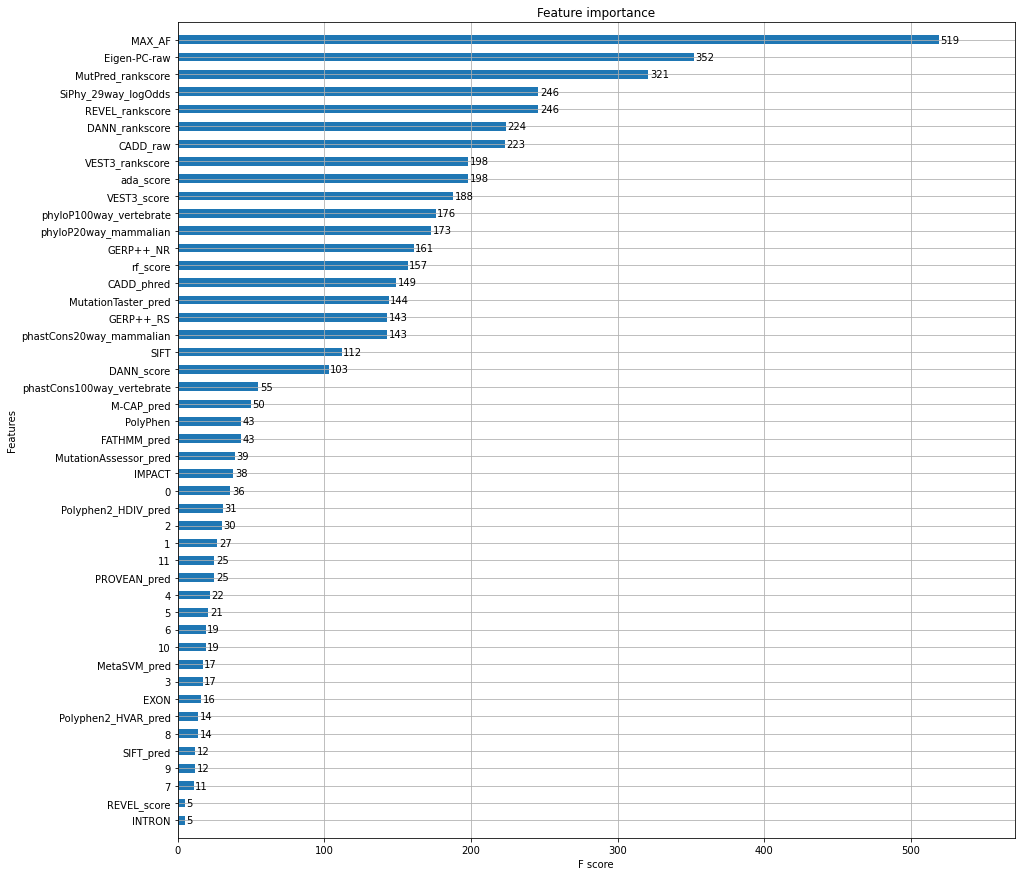

In [ ]:
fig, ax = plt.subplots(figsize=(15, 15))
plot_importance(bst, height=0.5, ax=ax)
# pyplot.show()
# bst.feature_importances_

In [115]:
joblib.dump(bst, 'XGBoostRegresor2.0.pkl')

NameError: name 'bst' is not defined